In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import optimizers, losses
from tensorflow.keras import Model

from collections import deque
import random
import datetime
import math

from tqdm import tqdm

from typing import Final


In [3]:
fData = pd.read_csv('../../preprocessed_data/[1분 단위]아파트_동별_소비전력_전력분배_2022-07-18 00.00.00~2023-08-30 10.39.00.csv',usecols=[1,2,3,4])

fData["CONSUMPTION(kWh)"] = (fData["561_CONSUMPTION(kW)"] + fData["562_CONSUMPTION(kW)"] + fData["563_CONSUMPTION(kW)"]) / 60
fData.drop(["561_CONSUMPTION(kW)", "562_CONSUMPTION(kW)", "563_CONSUMPTION(kW)"], axis = 1, inplace =True)

fData['TIMESTAMP'] = pd.to_datetime(fData['TIMESTAMP'])

fData.set_index('TIMESTAMP', inplace=True)
fData

,CONSUMPTION(kWh)
TIMESTAMP,
2022-07-18 00:00:00,2.804928
2022-07-18 00:01:00,2.870073
2022-07-18 00:02:00,2.867803
2022-07-18 00:03:00,2.856863
2022-07-18 00:04:00,2.794600
...,...
2023-08-30 10:35:00,2.019480
2023-08-30 10:36:00,1.984963
2023-08-30 10:37:00,2.045198


<Axes: xlabel='TIMESTAMP'>

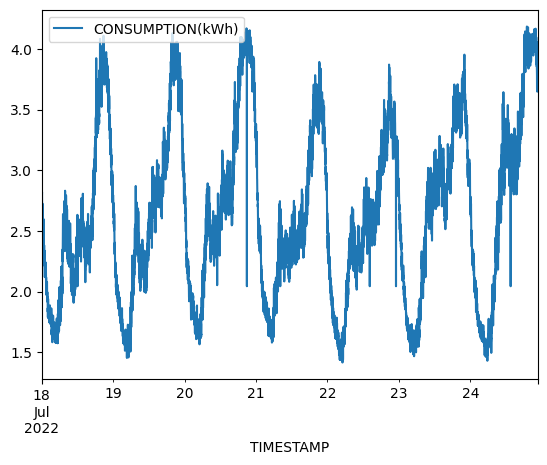

In [4]:
fData.iloc[0:10000].plot()

<Axes: xlabel='TIMESTAMP'>

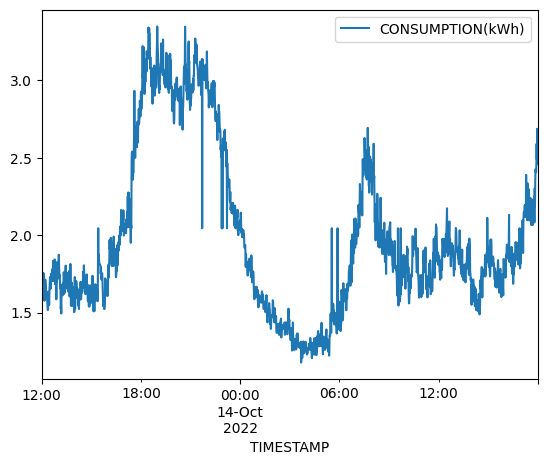

In [5]:
fData.iloc[126000:127800].plot()

In [6]:
fData = fData[:127800]
fData

,CONSUMPTION(kWh)
TIMESTAMP,
2022-07-18 00:00:00,2.804928
2022-07-18 00:01:00,2.870073
2022-07-18 00:02:00,2.867803
2022-07-18 00:03:00,2.856863
2022-07-18 00:04:00,2.794600
...,...
2022-10-14 17:55:00,2.590188
2022-10-14 17:56:00,2.488765
2022-10-14 17:57:00,2.686760


In [7]:
# def detect_outliers(df,columns):
#     q1=df[columns].quantile(0.25)
#     q3=df[columns].quantile(0.75)
#     iqr=q3-q1
    
#     boundary=1.5*iqr
    
#     index1=df[df[columns] > q3+boundary].index
#     index2=df[df[columns] < q1-boundary].index 
    
#     return index1, index2

In [8]:
# outliers = []
# length = 400

# for i in range(2*length, fData.size, length):
#     index1, index2 = detect_outliers(fData[i-length:i], "CONSUMPTION(kWh)")

#     outliers.extend(index1.to_list())
#     outliers.extend(index2.to_list())

# print(len(outliers))

# fData.loc[outliers] = np.nan

# fData.interpolate(method="time", inplace=True)

<Axes: xlabel='TIMESTAMP'>

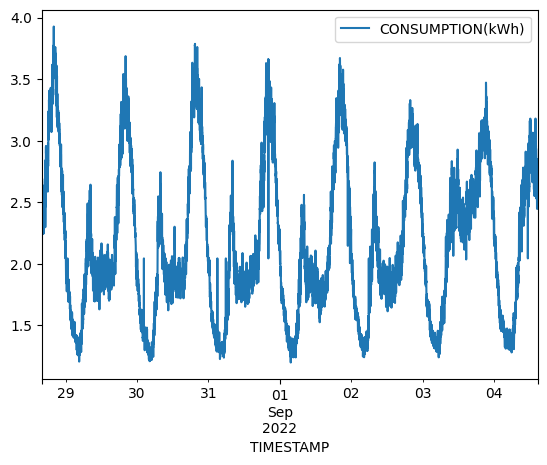

In [9]:
fData[60000:70000].plot()

In [10]:
fData.isna().sum()

CONSUMPTION(kWh)    0
dtype: int64

In [11]:
fData

,CONSUMPTION(kWh)
TIMESTAMP,
2022-07-18 00:00:00,2.804928
2022-07-18 00:01:00,2.870073
2022-07-18 00:02:00,2.867803
2022-07-18 00:03:00,2.856863
2022-07-18 00:04:00,2.794600
...,...
2022-10-14 17:55:00,2.590188
2022-10-14 17:56:00,2.488765
2022-10-14 17:57:00,2.686760


In [12]:
fData.loc['2022-07-18 00:00:00': '2022-08-31 23:59:00']

,CONSUMPTION(kWh)
TIMESTAMP,
2022-07-18 00:00:00,2.804928
2022-07-18 00:01:00,2.870073
2022-07-18 00:02:00,2.867803
2022-07-18 00:03:00,2.856863
2022-07-18 00:04:00,2.794600
...,...
2022-08-31 23:55:00,2.236018
2022-08-31 23:56:00,2.192385
2022-08-31 23:57:00,2.139060


In [13]:
fData.loc['2022-07-18 00:00:00': '2022-08-31 23:59:00'].size * 0.9

58320.0

In [14]:
fData = fData.loc['2022-07-18 00:00:00': '2022-08-31 23:59:00']

train_df = fData[:int(len(fData) * 0.9)]
test_df = fData[int(len(fData) * 0.9):]

In [15]:
train_df

,CONSUMPTION(kWh)
TIMESTAMP,
2022-07-18 00:00:00,2.804928
2022-07-18 00:01:00,2.870073
2022-07-18 00:02:00,2.867803
2022-07-18 00:03:00,2.856863
2022-07-18 00:04:00,2.794600
...,...
2022-08-27 11:55:00,2.338498
2022-08-27 11:56:00,2.406365
2022-08-27 11:57:00,2.324193


In [16]:
test_df

,CONSUMPTION(kWh)
TIMESTAMP,
2022-08-27 12:00:00,2.464548
2022-08-27 12:01:00,2.347222
2022-08-27 12:02:00,2.347222
2022-08-27 12:03:00,2.252675
2022-08-27 12:04:00,2.299083
...,...
2022-08-31 23:55:00,2.236018
2022-08-31 23:56:00,2.192385
2022-08-31 23:57:00,2.139060


In [17]:
# for i, row in fData.iterrows():
#     fData.loc[i] /= 1000
    
# fData.rename(columns = {'electric_energy_consumption(Wh)':'real_consumption(kWh)'}, inplace=True)
# fData


In [18]:
# fData = fData[1:]
fData.describe()


,CONSUMPTION(kWh)
count,64800.000000
mean,2.880028
std,0.815506
min,1.206117
25%,2.207909
50%,2.800783
75%,3.657125
max,4.192960


In [19]:
class Network(Model):
    def __init__(self, state_size: int, action_size: int, hidden_size: int
    ):
        super(Network, self).__init__()
        
        self.layer1 = tf.keras.layers.Dense(hidden_size, activation='relu')
        self.layer2 = tf.keras.layers.Dense(hidden_size, activation='relu')
        self.value = tf.keras.layers.Dense(action_size)

    def call(self, state):
        layer1 = self.layer1(state)
        layer2 = self.layer2(layer1)
        value = self.value(layer2)
        return value

In [20]:
class DQNAgent:
    def __init__(
        self, 
        batch_size: int,
        target_update: int,
        hidden_size: int,
        predict_len: int,
    ):
        # TOU parameters(KRW/kWh) 일반용(을) 고압A 선택2
        self.LOW_LOAD: Final = 79.3
        self.MIDDLE_LOAD: Final = 132.2
        self.HIGH_LOAD: Final = 214.3

        # battery parameters
        self.BATTERY_CAPACITY: Final = 10000 #kWh
        self.MIN_SOC: Final = 10
        self.MAX_SOC: Final = 90
        self.MAX_BATTERY_POWER: Final = self.BATTERY_CAPACITY / 2
        self.EFFICIENCY: Final = 0.9

        self.MARGIN = 0.15

        self.threshold = 3.657125
        self.margin_threshold = self.threshold * (1 - self.MARGIN)

        # network parameters
        self.state_size: Final = 2 + predict_len * 2
        self.action_space = [0.001, 0.01, 0.05, 0.1]
        for a in self.action_space:
            self.action_space.append(a * -1)
        self.append(0)

        self.action_size: Final = len(self.action_space)
        self.hidden_size: Final = hidden_size

        # hyper parameters
        self.lr: Final = 0.001
        self.gamma: Final = 0.95
        self.target_update: Final = target_update
        self.predict_len: Final = predict_len

        # replay memory
        self.memory = deque(maxlen=2000)
        self.batch_size: Final = batch_size

        self.dqn = Network(
            self.state_size, self.action_size, hidden_size
        )
        self.dqn_target = Network(
            self.state_size, self.action_size, hidden_size
        )
        
        self.optimizers = optimizers.Adam(learning_rate=self.lr, )
        
        self.target_hard_update()

    def initialize_episode(self, data):
        self.set_data(data)
        # self.set_threshold()

    # def set_threshold(self, threshold):
    #     self.threshold = threshold
    #     self.margin_threshold = self.threshold * (1 - self.MARGIN)
        # DAY_UNIT = 60 * 24

        # if len(self.data) < DAY_UNIT:
        #     self.threshold = self.data.max()[0] * 0.8
        # else :
        #     sum = 0
        #     for i in range(DAY_UNIT, len(self.data)+1, DAY_UNIT):
        #         sum += self.data[i-DAY_UNIT: i].max()[0]

        #     self.threshold = (sum / (len(self.data) // DAY_UNIT)) * 0.8

    def set_data(self, data):
        self.data = data

    def get_tou(self, timestmap : pd.Timestamp): # only summer
        if timestmap.hour >= 22 or timestmap.hour <= 7 : 
            return self.LOW_LOAD
        elif (timestmap.hour >= 11 and timestmap.hour <= 12) or (timestmap.hour >= 13 and timestmap.hour <= 18) : 
            return self.HIGH_LOAD
        else :
            return self.MIDDLE_LOAD

    def target_hard_update(self):
        self.dqn_target.set_weights(self.dqn.get_weights())

    def append_sample(self, state, action, reward, next_state):
        self.memory.append((state, action, reward, next_state))
        
    def get_action(self, state, epsilon):
        
        if np.random.rand() <= epsilon:
            action = np.random.choice(self.action_size)
        else:
            q_value = self.dqn(tf.convert_to_tensor([state], dtype=tf.float32))[0]
            action = np.argmax(q_value) 

        return action
    
    def take_step(self, state, action, step_num):
        
        #[SoC, battery power, power consumption_1, tou_1, pc_2, tou_2, pc3, tou_3, pc4,tou_4]
        
        next_state = [state[0]]
        # battery power
        next_state.append(state[1] + self.action_space[action])

        # power consumption
        for i in range(self.predict_len):
            next_state.append(self.data.iloc[step_num + i, 0])
            next_state.append(self.get_tou(self.data.iloc[step_num + i].name))

        # SoC
        next_state[0] += (next_state[1] / self.BATTERY_CAPACITY) * 100 * self.EFFICIENCY

        reward = self.__get_reward(state, next_state, action)

        return next_state, reward

    def normal_distribution_function(self, x, mean = 0, sigma = 1) :
        return math.pow(math.e, -math.pow(x - mean, 2) / (2 * (sigma ** 2)))
    
    def stepwise_function(self, x, end) :
        if x <= 0:
            return 0

        if end <= 0:
            return -x
        

        if x <= end :
            return x / end
        else :
            return -math.log(x - end)
        
    def __get_precise_reward(self, target, action, max_action, MAX_REWARD, MAX_PENALTY):
        if target > max_action:
            if action < 0:
                return MAX_REWARD * abs(action) / max_action
            else :
                return MAX_PENALTY
        elif target > 0:
            if action < 0:
                return MAX_REWARD * self.normal_distribution_function(abs(action), target)
            else :
                return MAX_PENALTY
        elif target == 0:
            if action == 0:
                return MAX_REWARD
            else :
                return MAX_PENALTY    
        elif target >= -max_action:
            if action > 0:
                return MAX_REWARD * self.normal_distribution_function(abs(action), abs(target))
            else :
                return MAX_PENALTY
        else:
            if action > 0:
                return MAX_REWARD * abs(action) / max_action
            else:
                return MAX_PENALTY

    def __get_reward(self, prev_state, next_state, action_idx):
        #[SoC, battery power, power consumption_1, tou_1, pc_2, tou_2, pc3, tou_3, pc4,tou_4]
        
        MAX_REWARD = 1e4
        MAX_PENALTY = -1e4

        prev_soc = prev_state[0]
        prev_battery_power = prev_state[1]
        prev_consumption = prev_state[2]
        prev_tou = prev_state[3]
    
        next_soc = next_state[0]
        next_battery_power = next_state[1]
        next_consumption = next_state[2]
        next_tou = next_state[3]

        final_next_consumption = next_state[-2]
        final_next_tou = next_state[-1]

        action = self.action_space[action_idx]
        max_action = max(self.action_space)


        if (abs(prev_battery_power) >= self.MAX_BATTERY_POWER and action >= 0) \
            or (prev_soc <= self.MIN_SOC and action <= 0) \
                or (prev_soc >= self.MAX_SOC and action >= 0):
            return MAX_PENALTY
        
        if next_consumption > self.threshold:
            if prev_battery_power >= 0:
                if action >= 0:
                    return MAX_PENALTY
                
                target = (next_consumption - self.margin_threshold) / self.EFFICIENCY
                if target > max_action:
                    return MAX_REWARD * abs(action) / max_action
                else:
                    return MAX_REWARD * self.normal_distribution_function(abs(action), target)

            else : # prev_battery_power < 0
                target = (next_consumption - self.margin_threshold + prev_battery_power * self.EFFICIENCY) / self.EFFICIENCY
                if target > max_action:
                    if action < 0:
                        return MAX_REWARD * abs(action) / max_action
                    else :
                        return MAX_PENALTY
                elif target > 0:
                    if action < 0:
                        return MAX_REWARD * self.normal_distribution_function(abs(action), target)
                    else :
                        return MAX_PENALTY
                elif target == 0:
                    if action == 0:
                        return MAX_REWARD
                    else :
                        return MAX_PENALTY    
                elif target >= -max_action:
                    if action > 0:
                        return MAX_REWARD * self.normal_distribution_function(abs(action), abs(target))
                    else :
                        return MAX_PENALTY
                else:
                    if action > 0:
                        return MAX_REWARD * abs(action) / max_action
                    else:
                        return MAX_PENALTY
                
        #elif next_consumption <= self.threshold: #restore 대비 소비전력 기울기 검증
        elif (next_tou == self.LOW_LOAD and final_next_tou == self.LOW_LOAD) \
             and (final_next_consumption - next_consumption) / float(self.predict_len) < 0.4 \
                  and prev_soc < 60:
            
            if action > 0 :
                return MAX_REWARD * action / max_action
            else :
                return MAX_PENALTY
                
                
        # endif next_tou == self.LOW_LOAD:      
        else : # 배터리 파워가 0에 가까워질수록 보상
            target = -prev_battery_power

            if abs(target) > max_action:
                if target > 0 :
                    if action > 0 :
                        return MAX_REWARD * action / max_action
                    else :
                        return MAX_PENALTY
                elif target == 0:
                    if action == 0:
                        return MAX_REWARD
                    else :
                        return MAX_PENALTY
                else :
                    if action < 0 :
                        return MAX_REWARD * abs(action) / max_action
                    else :
                        return MAX_PENALTY
                    
            else :
                if target > 0:
                    if action > 0:
                        return MAX_REWARD * self.normal_distribution_function(action, target)
                    else :
                        return MAX_PENALTY
                elif target == 0:
                    if action == 0:
                        return MAX_REWARD
                    else :
                        return MAX_PENALTY
                else :
                    if action < 0 :
                        return MAX_REWARD * self.normal_distribution_function(abs(action), abs(target))
                    else :
                        return MAX_PENALTY


    def train_step(self):
        mini_batch = random.sample(self.memory, self.batch_size)

        states      = [[i[0]] for i in mini_batch]
        actions     = [i[1] for i in mini_batch]
        rewards     = [i[2] for i in mini_batch]
        next_states = [[i[3]] for i in mini_batch]
        
        dqn_variable = self.dqn.trainable_variables
        with tf.GradientTape() as tape:
            tape.watch(dqn_variable)
            
            states      = tf.convert_to_tensor(np.vstack(states), dtype=tf.float32)
            actions     = tf.convert_to_tensor(actions, dtype=tf.int32)
            rewards     = tf.convert_to_tensor(rewards, dtype=tf.float32)
            next_states = tf.convert_to_tensor(np.vstack(next_states), dtype=tf.float32)
            
            curr_Qs    = self.dqn(states)
            main_value = tf.reduce_sum(tf.one_hot(actions, self.action_size) * curr_Qs, axis=1)

            next_Qtargets = self.dqn_target(next_states)
            next_action = tf.argmax(next_Qtargets, axis=1)
            target_value = tf.reduce_sum(tf.one_hot(next_action, self.action_size) * next_Qtargets, axis=1)

            error = tf.square(main_value - (rewards + self.gamma * target_value)) * 0.5
            loss  = tf.reduce_mean(error)
            
        dqn_grads = tape.gradient(loss, dqn_variable)
        self.optimizers.apply_gradients(zip(dqn_grads, dqn_variable))

In [21]:
2*(train_df.max()[0] - train_df.min()[0]) - (train_df.max()[0] - train_df.min()[0])

C:\Users\hansung\AppData\Local\Temp\ipykernel_3896\2035781946.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  2*(train_df.max()[0] - train_df.min()[0]) - (train_df.max()[0] - train_df.min()[0])


2.8957097371794873

In [22]:
# hyper parameters
hidden_size = 64
max_episodes = 10000
batch_size = 64
max_steps = 100

target_update = 10
update_cnt = 0

predict_len = 3

consumption_gap = train_df.max()[0] - train_df.min()[0]

# Exploration parameters
epsilon = 1.0                 
max_epsilon = 1.0             
min_epsilon = 0.01            
decay_rate = 0.005            


agent = DQNAgent(
    batch_size,
    target_update,
    hidden_size,
    predict_len
)

scores = []

# for episode in tqdm(range(max_episodes), desc='episode', position=0, leave=True):
with tqdm(range(max_episodes)) as tr:
    for episode in tr:
        #initial value [SoC, battery power, power consumption_1, tou_1, power consumption_2, tou_2, pc3, tou_3, pc4,tou_4]
        start_num = int((len(train_df) - max_steps - predict_len - 1) * np.random.rand())

        state = [np.random.rand() * 80 + 10, 2 * consumption_gap * np.random.rand() - consumption_gap]
        
        for i in range(predict_len):
            state.append(train_df.iloc[start_num + i,0])
            state.append(agent.get_tou(train_df.iloc[start_num + i].name))

        agent.initialize_episode(train_df[start_num : start_num + max_steps + predict_len + 1])
        
        episode_reward = 0
        #for step in tqdm(range(1, max_steps + 1), desc='step', position=1, leave=False):
        for step in range(1, max_steps + 1):
            action = agent.get_action(state, epsilon)
            
            next_state, reward = agent.take_step(state, action, step)
            agent.append_sample(state, action, reward, next_state)
            
            state = next_state

            episode_reward += reward

            if len(agent.memory) >= agent.batch_size:
                agent.train_step()
                update_cnt += 1

                if update_cnt % agent.target_update == 0 :
                    agent.target_hard_update()
            
        epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode) 
           
        scores.append(episode_reward)
        tr.set_postfix(reward=f'{episode_reward}')

C:\Users\hansung\AppData\Local\Temp\ipykernel_3896\2885719662.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  consumption_gap = train_df.max()[0] - train_df.min()[0]


<Axes: >

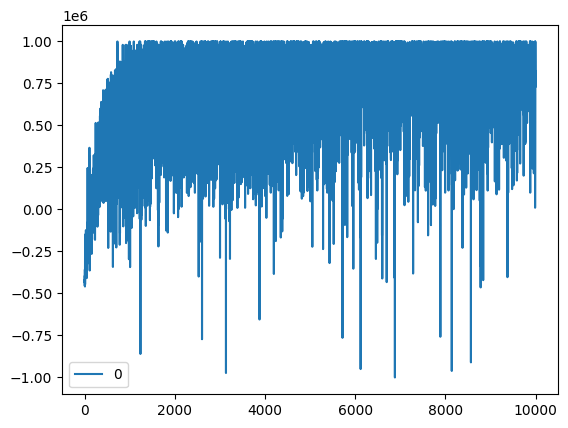

In [ ]:
pd.DataFrame(scores).plot()

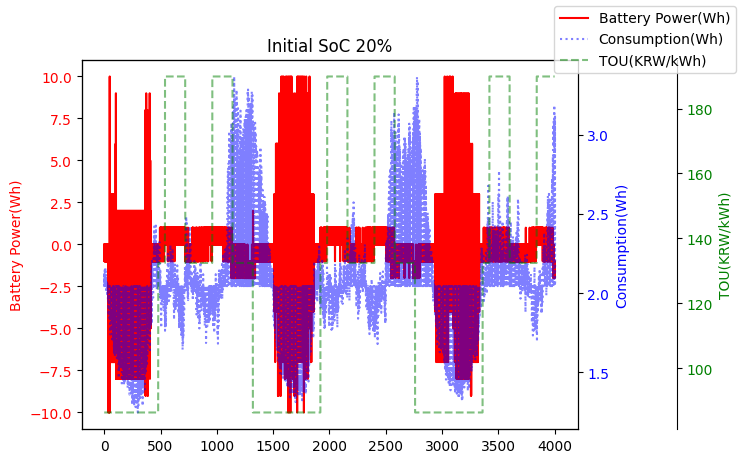

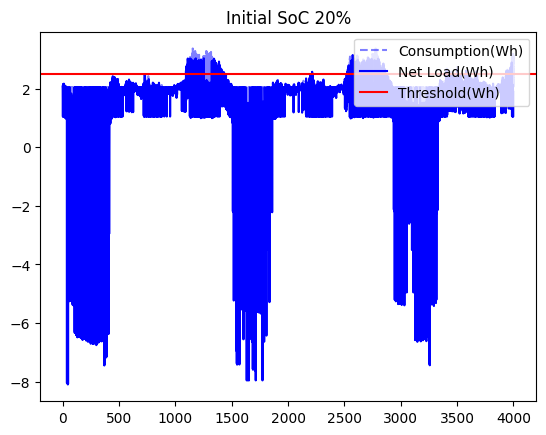

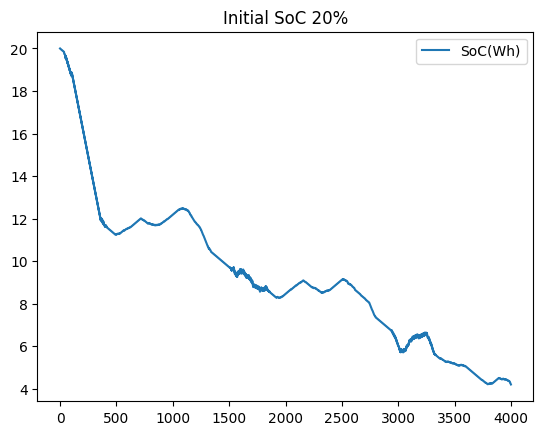

In [ ]:
simulation_len = 4000

# agent.initialize_episode(test_df[:simulation_len])
agent.set_data(test_df[:simulation_len + predict_len + 1])

initial_soc = 20

state = [initial_soc, 0]
for i in range(predict_len):
    state.append(agent.data.iloc[i+1, 0])
    state.append(agent.get_tou(agent.data.iloc[i+1].name))

#[SoC, battery power, power consumption_1, tou_1, power consumption_2, tou_2, pc3, tou_3, pc4,tou_4]

powers = [state[1]]
SoCs = [state[0]] 
net_loads = [state[1] + state[2]]
tous = [state[3]]
for step in range(1, simulation_len):
    q_value = agent.dqn(tf.convert_to_tensor([state], dtype=tf.float32))[0]
    action = np.argmax(q_value) 

    next_state, reward = agent.take_step(state, action, step) 
    
    state = next_state
    powers.append(state[1])
    SoCs.append(state[0])
    net_loads.append(min(state[1],0) + state[2])
    tous.append(state[3])

# df = pd.DataFrame({'timestamp' : pd.date_range(test_df[:simulation_len].index[0] + datetime.timedelta(minutes=1), freq='T', periods = simulation_len, tz = None),
#                     'power(kW)' : powers})
# df.set_index('timestamp', inplace=True)

fig, ax1 = plt.subplots()
plt.title(f"Initial SoC {initial_soc}%")

color1 = 'red'
ax1.plot(powers, color = color1, label = 'Battery Power(Wh)', linestyle='-')
ax1.set_ylabel('Battery Power(Wh)', color = color1, rotation = 90)
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx();
color2 = 'blue'
ax2.plot(agent.data.values.flatten(), color = color2, alpha=0.5, label = 'Consumption(Wh)', linestyle=':')
ax2.set_ylabel('Consumption(Wh)', color = color2, rotation = 90)
ax2.tick_params(axis='y', labelcolor=color2)

ax3 = ax1.twinx()
color3 = 'green'
ax3.plot(tous, color = color3, alpha=0.5, label = 'TOU(KRW/kWh)', linestyle='--')
ax3.set_ylabel('TOU(KRW/kWh)', color = color3, rotation = 90)
ax3.tick_params(axis='y', labelcolor=color3)
ax3.spines.right.set_position(('axes', 1.2))
fig.legend(loc='upper right')
plt.show()

plt.title(f"Initial SoC {initial_soc}%")
color1 = 'blue'
plt.plot(agent.data.values.flatten(), color = color1, alpha=0.5, label='Consumption(Wh)', linestyle='--')
plt.plot(pd.DataFrame({'Net_Load' : net_loads}), color = color1, label='Net Load(Wh)')
plt.axhline(agent.threshold, color='r', label='Threshold(Wh)')
plt.legend(loc='upper right')
plt.show()

plt.title(f"Initial SoC {initial_soc}%")
plt.plot(pd.DataFrame({'SoC' : SoCs}), label='SoC(Wh)')
plt.legend(loc='upper right')
plt.show()

    

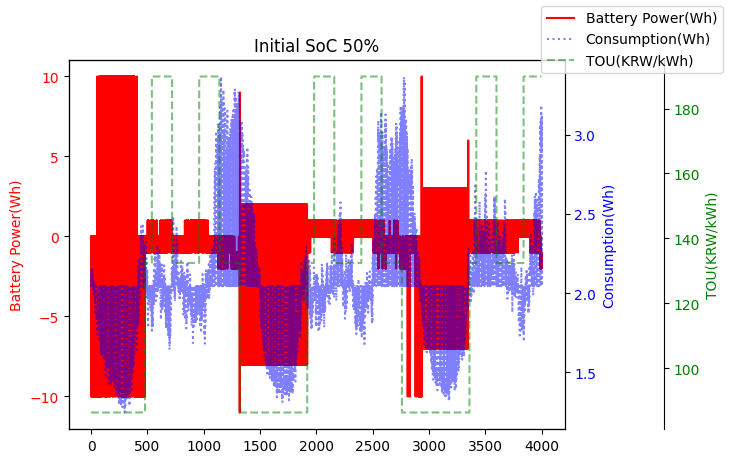

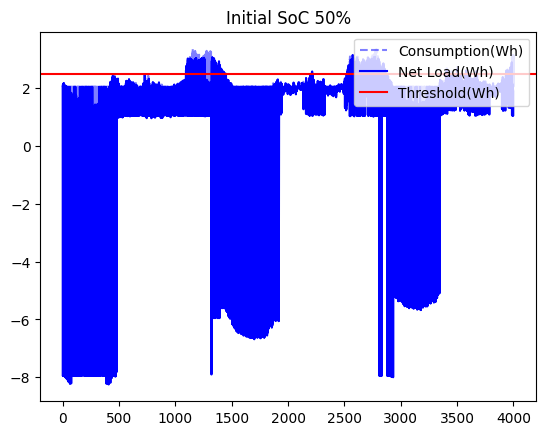

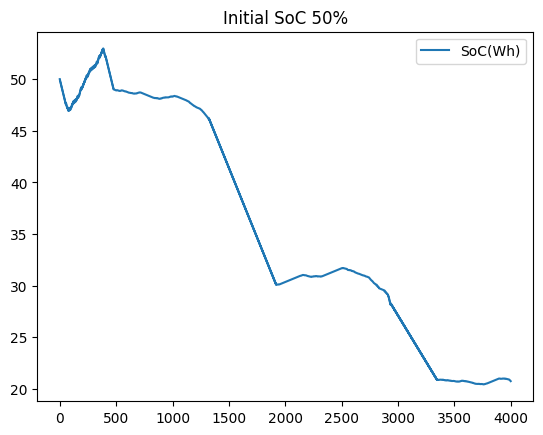

In [ ]:
simulation_len = 4000

# agent.initialize_episode(test_df[:simulation_len])
agent.set_data(test_df[:simulation_len + predict_len + 1])

initial_soc = 50

state = [initial_soc, 0]
for i in range(predict_len):
    state.append(agent.data.iloc[i+1, 0])
    state.append(agent.get_tou(agent.data.iloc[i+1].name))

#[SoC, battery power, power consumption_1, tou_1, power consumption_2, tou_2, pc3, tou_3, pc4,tou_4]

powers = [state[1]]
SoCs = [state[0]] 
net_loads = [state[1] + state[2]]
tous = [state[3]]
for step in range(1, simulation_len):
    q_value = agent.dqn(tf.convert_to_tensor([state], dtype=tf.float32))[0]
    action = np.argmax(q_value) 

    next_state, reward = agent.take_step(state, action, step) 
    
    state = next_state
    powers.append(state[1])
    SoCs.append(state[0])
    net_loads.append(min(state[1],0) + state[2])
    tous.append(state[3])

# df = pd.DataFrame({'timestamp' : pd.date_range(test_df[:simulation_len].index[0] + datetime.timedelta(minutes=1), freq='T', periods = simulation_len, tz = None),
#                     'power(kW)' : powers})
# df.set_index('timestamp', inplace=True)

fig, ax1 = plt.subplots()
plt.title(f"Initial SoC {initial_soc}%")

color1 = 'red'
ax1.plot(powers, color = color1, label = 'Battery Power(Wh)', linestyle='-')
ax1.set_ylabel('Battery Power(Wh)', color = color1, rotation = 90)
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx();
color2 = 'blue'
ax2.plot(agent.data.values.flatten(), color = color2, alpha=0.5, label = 'Consumption(Wh)', linestyle=':')
ax2.set_ylabel('Consumption(Wh)', color = color2, rotation = 90)
ax2.tick_params(axis='y', labelcolor=color2)

ax3 = ax1.twinx()
color3 = 'green'
ax3.plot(tous, color = color3, alpha=0.5, label = 'TOU(KRW/kWh)', linestyle='--')
ax3.set_ylabel('TOU(KRW/kWh)', color = color3, rotation = 90)
ax3.tick_params(axis='y', labelcolor=color3)
ax3.spines.right.set_position(('axes', 1.2))
fig.legend(loc='upper right')
plt.show()

plt.title(f"Initial SoC {initial_soc}%")
color1 = 'blue'
plt.plot(agent.data.values.flatten(), color = color1, alpha=0.5, label='Consumption(Wh)', linestyle='--')
plt.plot(pd.DataFrame({'Net_Load' : net_loads}), color = color1, label='Net Load(Wh)')
plt.axhline(agent.threshold, color='r', label='Threshold(Wh)')
plt.legend(loc='upper right')
plt.show()

plt.title(f"Initial SoC {initial_soc}%")
plt.plot(pd.DataFrame({'SoC' : SoCs}), label='SoC(Wh)')
plt.legend(loc='upper right')
plt.show()

    

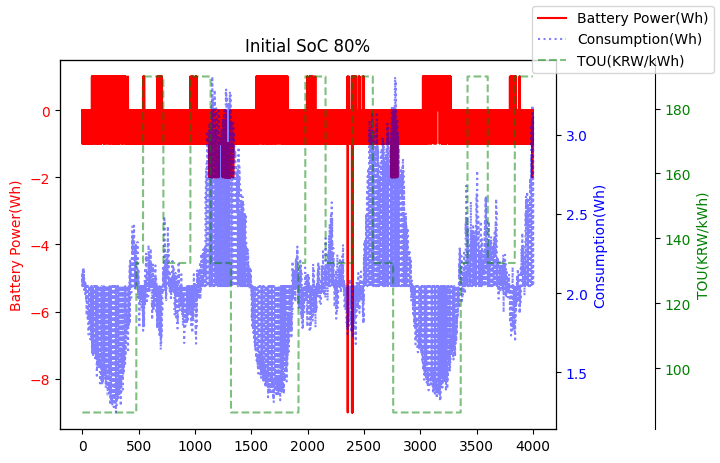

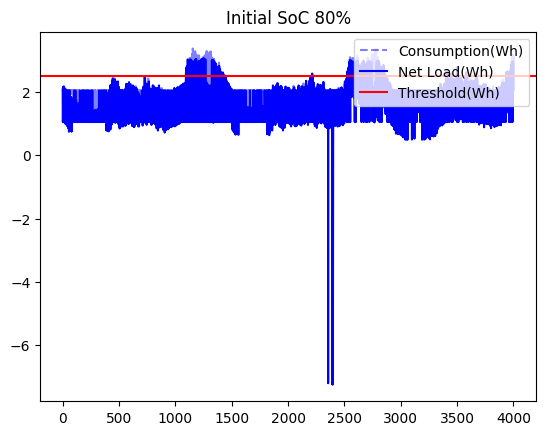

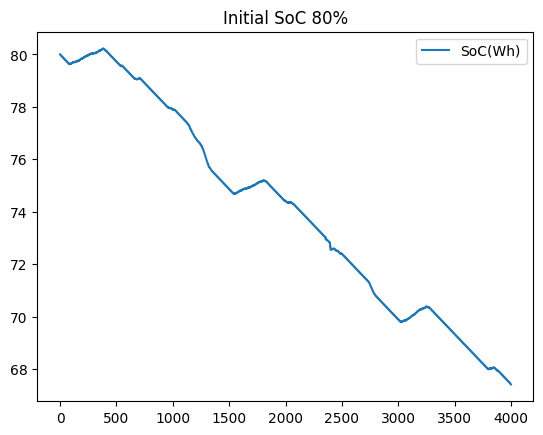

In [ ]:
simulation_len = 4000

# agent.initialize_episode(test_df[:simulation_len])
agent.set_data(test_df[:simulation_len + predict_len + 1])

initial_soc = 80

state = [initial_soc, 0]
for i in range(predict_len):
    state.append(agent.data.iloc[i+1, 0])
    state.append(agent.get_tou(agent.data.iloc[i+1].name))

#[SoC, battery power, power consumption_1, tou_1, power consumption_2, tou_2, pc3, tou_3, pc4,tou_4]

powers = [state[1]]
SoCs = [state[0]] 
net_loads = [state[1] + state[2]]
tous = [state[3]]
for step in range(1, simulation_len):
    q_value = agent.dqn(tf.convert_to_tensor([state], dtype=tf.float32))[0]
    action = np.argmax(q_value) 

    next_state, reward = agent.take_step(state, action, step) 
    
    state = next_state
    powers.append(state[1])
    SoCs.append(state[0])
    net_loads.append(min(state[1],0) + state[2])
    tous.append(state[3])

# df = pd.DataFrame({'timestamp' : pd.date_range(test_df[:simulation_len].index[0] + datetime.timedelta(minutes=1), freq='T', periods = simulation_len, tz = None),
#                     'power(kW)' : powers})
# df.set_index('timestamp', inplace=True)

fig, ax1 = plt.subplots()
plt.title(f"Initial SoC {initial_soc}%")

color1 = 'red'
ax1.plot(powers, color = color1, label = 'Battery Power(Wh)', linestyle='-')
ax1.set_ylabel('Battery Power(Wh)', color = color1, rotation = 90)
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx();
color2 = 'blue'
ax2.plot(agent.data.values.flatten(), color = color2, alpha=0.5, label = 'Consumption(Wh)', linestyle=':')
ax2.set_ylabel('Consumption(Wh)', color = color2, rotation = 90)
ax2.tick_params(axis='y', labelcolor=color2)

ax3 = ax1.twinx()
color3 = 'green'
ax3.plot(tous, color = color3, alpha=0.5, label = 'TOU(KRW/kWh)', linestyle='--')
ax3.set_ylabel('TOU(KRW/kWh)', color = color3, rotation = 90)
ax3.tick_params(axis='y', labelcolor=color3)
ax3.spines.right.set_position(('axes', 1.2))
fig.legend(loc='upper right')
plt.show()

plt.title(f"Initial SoC {initial_soc}%")
color1 = 'blue'
plt.plot(agent.data.values.flatten(), color = color1, alpha=0.5, label='Consumption(Wh)', linestyle='--')
plt.plot(pd.DataFrame({'Net_Load' : net_loads}), color = color1, label='Net Load(Wh)')
plt.axhline(agent.threshold, color='r', label='Threshold(Wh)')
plt.legend(loc='upper right')
plt.show()

plt.title(f"Initial SoC {initial_soc}%")
plt.plot(pd.DataFrame({'SoC' : SoCs}), label='SoC(Wh)')
plt.legend(loc='upper right')
plt.show()

    